## Objective

Discover "if-then" type rules that reveal meaningful relationships between candidates' characteristics (sex, track, series, establishment features) and their exam results (success, mentions).

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Database + modeling
import pyodbc
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# Optional methods
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False

import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
import time


def connect_to_sql_server(max_retries: int = 3, retry_delay: int = 3):
    """Connect to the local SQL Server instance with simple retry logic.

    Returns
    -------
    conn : pyodbc.Connection
        Open connection to the `etablissement` database.
    """
    connection_string = (
        "Driver={SQL Server};"
        "Server=localhost;"
        "Database=etablissement;"
        "Trusted_Connection=yes;"
        "Connection Timeout=60;"
    )

    for attempt in range(1, max_retries + 1):
        try:
            conn = pyodbc.connect(connection_string, timeout=60)
            print("Connected to SQL Server.")
            return conn
        except Exception as e:
            if attempt < max_retries:
                print(f"Connection failed (attempt {attempt}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Connection failed after {max_retries} attempts: {e}")
                raise


conn = connect_to_sql_server()

Connected to SQL Server.


In [3]:
# Load candidate-level data from the data warehouse
print("Loading candidate data from SQL Server (this may take a few minutes)...")

query_candidates = """
SELECT 
    -- Candidate characteristics
    dc.id_can,
    dc.sexe,
    dc.statut_candidat,
    
    -- Training program
    df.id_for,
    df.voie,
    df.serie,
    df.diplome_specialite,
    
    -- Establishment features (via fact_table_etab)
    fte.id_fact_table,
    fte.Hebergement,
    fte.Restauration,
    fte.International AS Section_internationale,
    fte.score AS Average_Score_moyen,
    
    -- Establishment type (via dim_etablissement)
    de.type_etablissement,
    de.greta AS GRETA,
    de.pial AS PIAL,
    
    -- Results
    fr.nb_inscrits,
    fr.nb_presents,
    fr.nb_admis_totaux,
    fr.nb_refuses_totaux,
    fr.nb_admis_mention_TB_felicitations,
    fr.nb_admis_mention_TB,
    fr.nb_admis_mention_B,
    fr.nb_admis_mention_AB,
    fr.nb_admis_sans_mention
    
FROM fact_resultats fr
LEFT JOIN dim_candidat dc ON fr.id_can = dc.id_can
LEFT JOIN dim_formation df ON fr.id_for = df.id_for
LEFT JOIN fact_table_etab fte ON fr.id_fact = fte.id_fact_table
LEFT JOIN dim_etablissement de ON fte.id = de.id
WHERE fr.id_can IS NOT NULL
  AND fr.nb_inscrits > 0;
"""


def execute_query_with_retry(query, conn, max_retries: int = 3, retry_delay: int = 3) -> pd.DataFrame:
    """Execute a SQL query with basic retry and chunked loading for large tables."""
    for attempt in range(max_retries):
        try:
            # Quick connection check
            try:
                _ = pd.read_sql("SELECT 1 AS test", conn)
            except Exception:
                try:
                    conn.close()
                except Exception:
                    pass
                conn = connect_to_sql_server()

            chunk_size = 5000
            chunks = []
            total_rows = 0

            for chunk in pd.read_sql(query, conn, chunksize=chunk_size):
                chunks.append(chunk)
                total_rows += len(chunk)
                if total_rows % (5 * chunk_size) == 0:
                    print(f"  {total_rows:,} rows loaded...")

            if not chunks:
                print("No data returned.")
                return pd.DataFrame()

            df = pd.concat(chunks, ignore_index=True)
            print(f"Loaded candidate data: {df.shape[0]:,} rows, {df.shape[1]} columns.")
            return df

        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Error while reading data (attempt {attempt + 1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                try:
                    conn.close()
                except Exception:
                    pass
                conn = connect_to_sql_server()
            else:
                print(f"Failed to load data after {max_retries} attempts: {e}")
                try:
                    conn.close()
                except Exception:
                    pass
                raise


df = execute_query_with_retry(query_candidates, conn)

Loading candidate data from SQL Server (this may take a few minutes)...
  25,000 rows loaded...
  50,000 rows loaded...
  75,000 rows loaded...
  100,000 rows loaded...
  125,000 rows loaded...
  150,000 rows loaded...
  175,000 rows loaded...
  200,000 rows loaded...
  225,000 rows loaded...
Loaded candidate data: 240,597 rows, 24 columns.


In [5]:
print("Cleaning and engineering candidate-level features...")

# Work on a copy
df_clean = df.copy()

# Encode sex
if "sexe" in df_clean.columns:
    df_clean["Sexe_Male"] = (
        df_clean["sexe"].str.upper().str.strip().str.contains("M", na=False)
    ).astype(int)
    df_clean["Sexe_Female"] = (
        df_clean["sexe"].str.upper().str.strip().str.contains("F", na=False)
    ).astype(int)

# Outcome variables
df_clean["Reussite"] = (df_clean["nb_admis_totaux"] > 0).astype(int)

df_clean["Mention_TB"] = (df_clean["nb_admis_mention_TB"] > 0).astype(int)
df_clean["Mention_TB_Felicitations"] = (
    df_clean["nb_admis_mention_TB_felicitations"] > 0
).astype(int)
df_clean["Mention_B"] = (df_clean["nb_admis_mention_B"] > 0).astype(int)
df_clean["Mention_AB"] = (df_clean["nb_admis_mention_AB"] > 0).astype(int)
df_clean["Sans_Mention"] = (df_clean["nb_admis_sans_mention"] > 0).astype(int)

# Track (voie)
if "voie" in df_clean.columns:
    df_clean["Voie_generale"] = df_clean["voie"].str.contains(
        "general", case=False, na=False
    ).astype(int)
    df_clean["Voie_technologique"] = df_clean["voie"].str.contains(
        "technologique", case=False, na=False
    ).astype(int)
    df_clean["Voie_professionnelle"] = df_clean["voie"].str.contains(
        "professionnel", case=False, na=False
    ).astype(int)

# Series (binned)
if "serie" in df_clean.columns:
    main_series = ["S", "ES", "L", "STI", "STL", "STD2A", "STMG", "ST2S", "STAV"]
    for serie in main_series:
        col_name = f"Serie_{serie}"
        df_clean[col_name] = df_clean["serie"].str.contains(
            serie, case=False, na=False
        ).astype(int)

# Establishment binary features
binary_cols_etab = ["Hebergement", "Restauration", "Section_internationale", "GRETA", "PIAL"]
for col in binary_cols_etab:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce").fillna(0).astype(int)

# Average score: impute missing with median
if "Average_Score_moyen" in df_clean.columns:
    median_score = df_clean["Average_Score_moyen"].median()
    df_clean["Average_Score_moyen"] = df_clean["Average_Score_moyen"].fillna(median_score)

# Global NA handling
df_clean = df_clean.fillna(0)

print(f"Cleaned data shape: {df_clean.shape[0]:,} rows, {df_clean.shape[1]} columns.")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

Cleaning and engineering candidate-level features...
Cleaned data shape: 240,597 rows, 44 columns.
Remaining missing values: 0


In [6]:
print("Selecting candidate-level features for clustering...")

# Manually selected features (no series to avoid redundancy with tracks)
features_manual = [
    "Sexe_Male",
    "Voie_generale",
    "Voie_technologique",
    "Voie_professionnelle",
    "Reussite",
    "Mention_TB",
    "Mention_B",
    "Mention_AB",
    "Sans_Mention",
    "Average_Score_moyen",
    "Hebergement",
    "Restauration",
]

# Keep only existing columns
features_manual = [col for col in features_manual if col in df_clean.columns]

print(f"Features used for clustering ({len(features_manual)}):")
for i, col in enumerate(features_manual, 1):
    print(f"  {i:2d}. {col}")

# Quick variance check
variances = df_clean[features_manual].var()
print("\nVariance by feature:")
for col in features_manual:
    print(f"  {col:25s}: {variances[col]:.4f}")

X_validation = df_clean[features_manual].copy()

Selecting candidate-level features for clustering...
Features used for clustering (12):
   1. Sexe_Male
   2. Voie_generale
   3. Voie_technologique
   4. Voie_professionnelle
   5. Reussite
   6. Mention_TB
   7. Mention_B
   8. Mention_AB
   9. Sans_Mention
  10. Average_Score_moyen
  11. Hebergement
  12. Restauration

Variance by feature:
  Sexe_Male                : 0.2436
  Voie_generale            : 0.0203
  Voie_technologique       : 0.1426
  Voie_professionnelle     : 0.1558
  Reussite                 : 0.0851
  Mention_TB               : 0.2350
  Mention_B                : 0.2418
  Mention_AB               : 0.2146
  Sans_Mention             : 0.1877
  Average_Score_moyen      : 10.7503
  Hebergement              : 0.0166
  Restauration             : 0.0536


In [7]:
print("Validating feature set (variance and correlation)...")

# Variance
variances = X_validation.var()

high_variance_cols = variances[variances > variances.quantile(0.5)].index.tolist()
print(f"High-variance features (>= median): {len(high_variance_cols)}")
print(high_variance_cols)

# Correlation
corr_matrix = X_validation.corr()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append(
                (
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j],
                )
            )

if high_corr_pairs:
    print("Highly correlated pairs (|corr| > 0.7):")
    for col1, col2, corr in high_corr_pairs:
        print(f"  {col1} vs {col2}: {corr:.3f}")
else:
    print("No excessive correlations detected (all |corr| <= 0.7).")

Validating feature set (variance and correlation)...
High-variance features (>= median): 6
['Sexe_Male', 'Mention_TB', 'Mention_B', 'Mention_AB', 'Sans_Mention', 'Average_Score_moyen']
Highly correlated pairs (|corr| > 0.7):
  Voie_technologique vs Voie_professionnelle: -0.933


In [8]:
print("Preparing data for clustering (standardization)...")

X_clustering = df_clean[features_manual].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

print(f"Standardized data shape: {X_scaled.shape}")

Preparing data for clustering (standardization)...
Standardized data shape: (240597, 12)


Searching for optimal K (Elbow, Silhouette, Davies-Bouldin)...
Optimal K (by Silhouette): 15


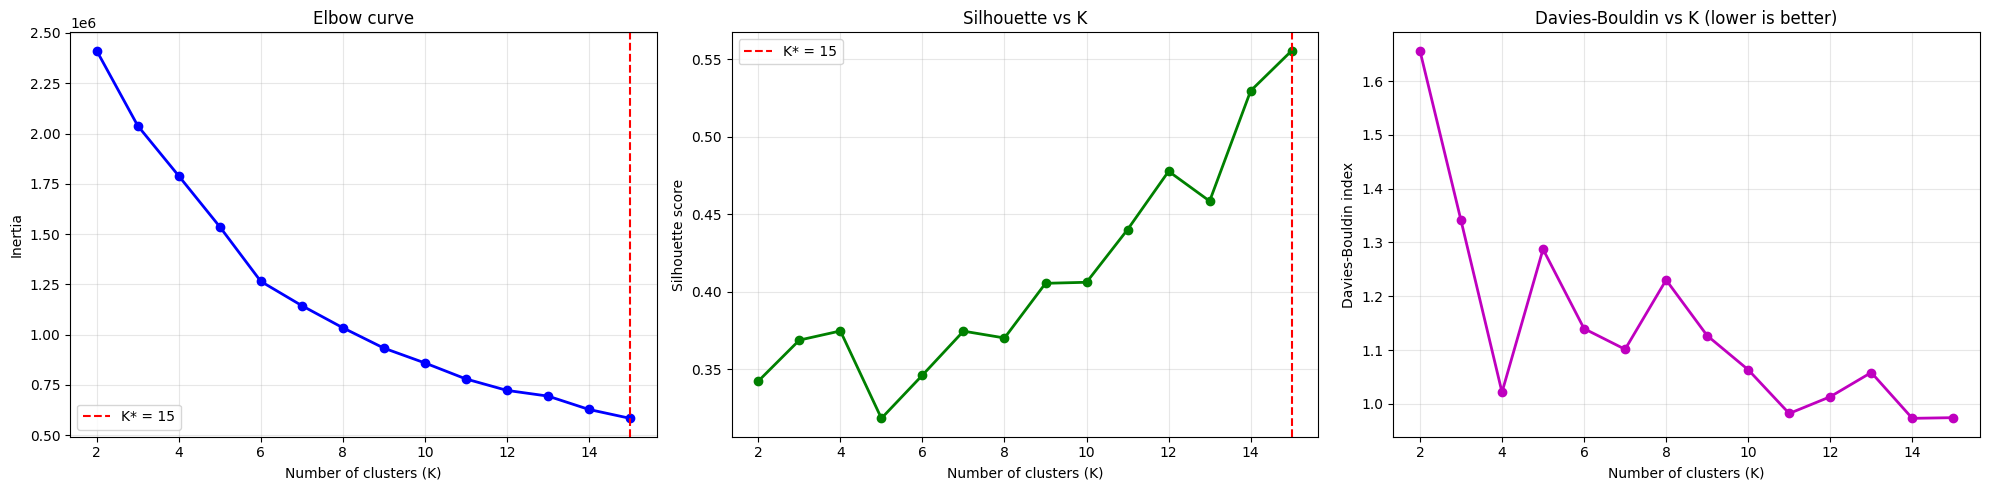

In [9]:
print("Searching for optimal K (Elbow, Silhouette, Davies-Bouldin)...")

K_range = range(2, 16)
inertias = []
silhouette_scores_list = []
davies_bouldin_scores = []

n_samples = len(X_scaled)
if n_samples > 10_000:
    sample_size = 10_000
else:
    sample_size = None

for k in K_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_tmp.fit(X_scaled)
    labels_tmp = kmeans_tmp.labels_

    inertias.append(kmeans_tmp.inertia_)
    silhouette_scores_list.append(
        silhouette_score(X_scaled, labels_tmp, sample_size=sample_size, random_state=42)
    )
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels_tmp))

optimal_k = K_range[np.argmax(silhouette_scores_list)]

print(f"Optimal K (by Silhouette): {optimal_k}")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(K_range, inertias, "bo-", linewidth=2, markersize=6)
axes[0].axvline(x=optimal_k, color="red", linestyle="--", label=f"K* = {optimal_k}")
axes[0].set_xlabel("Number of clusters (K)")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Elbow curve")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores_list, "go-", linewidth=2, markersize=6)
axes[1].axvline(x=optimal_k, color="red", linestyle="--", label=f"K* = {optimal_k}")
axes[1].set_xlabel("Number of clusters (K)")
axes[1].set_ylabel("Silhouette score")
axes[1].set_title("Silhouette vs K")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(K_range, davies_bouldin_scores, "mo-", linewidth=2, markersize=6)
axes[2].set_xlabel("Number of clusters (K)")
axes[2].set_ylabel("Davies-Bouldin index")
axes[2].set_title("Davies-Bouldin vs K (lower is better)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_clusters = optimal_k

In [10]:
print("Fitting final K-Means model...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)

df_clean["Cluster_KMeans"] = clusters_kmeans

cluster_counts = df_clean["Cluster_KMeans"].value_counts().sort_index()
print("Cluster distribution (K-Means):")
for cluster_id, count in cluster_counts.items():
    pct = count / len(df_clean) * 100
    print(f"  Cluster {cluster_id}: {count:,} candidates ({pct:.1f}%)")

silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, clusters_kmeans)
calinski_harabasz_kmeans = calinski_harabasz_score(X_scaled, clusters_kmeans)

print("K-Means quality metrics:")
print(f"  Silhouette: {silhouette_kmeans:.3f}")
print(f"  Davies-Bouldin: {davies_bouldin_kmeans:.3f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_kmeans:.2f}")

Fitting final K-Means model...
Cluster distribution (K-Means):
  Cluster 0: 27,906 candidates (11.6%)
  Cluster 1: 28,565 candidates (11.9%)
  Cluster 2: 19,964 candidates (8.3%)
  Cluster 3: 18,094 candidates (7.5%)
  Cluster 4: 16,619 candidates (6.9%)
  Cluster 5: 4,904 candidates (2.0%)
  Cluster 6: 29,140 candidates (12.1%)
  Cluster 7: 3,952 candidates (1.6%)
  Cluster 8: 12,371 candidates (5.1%)
  Cluster 9: 3,122 candidates (1.3%)
  Cluster 10: 5,763 candidates (2.4%)
  Cluster 11: 33,964 candidates (14.1%)
  Cluster 12: 5,059 candidates (2.1%)
  Cluster 13: 16,759 candidates (7.0%)
  Cluster 14: 14,415 candidates (6.0%)
K-Means quality metrics:
  Silhouette: 0.550
  Davies-Bouldin: 0.974
  Calinski-Harabasz: 67777.19


Visualizing K-Means clusters with PCA (2D)...


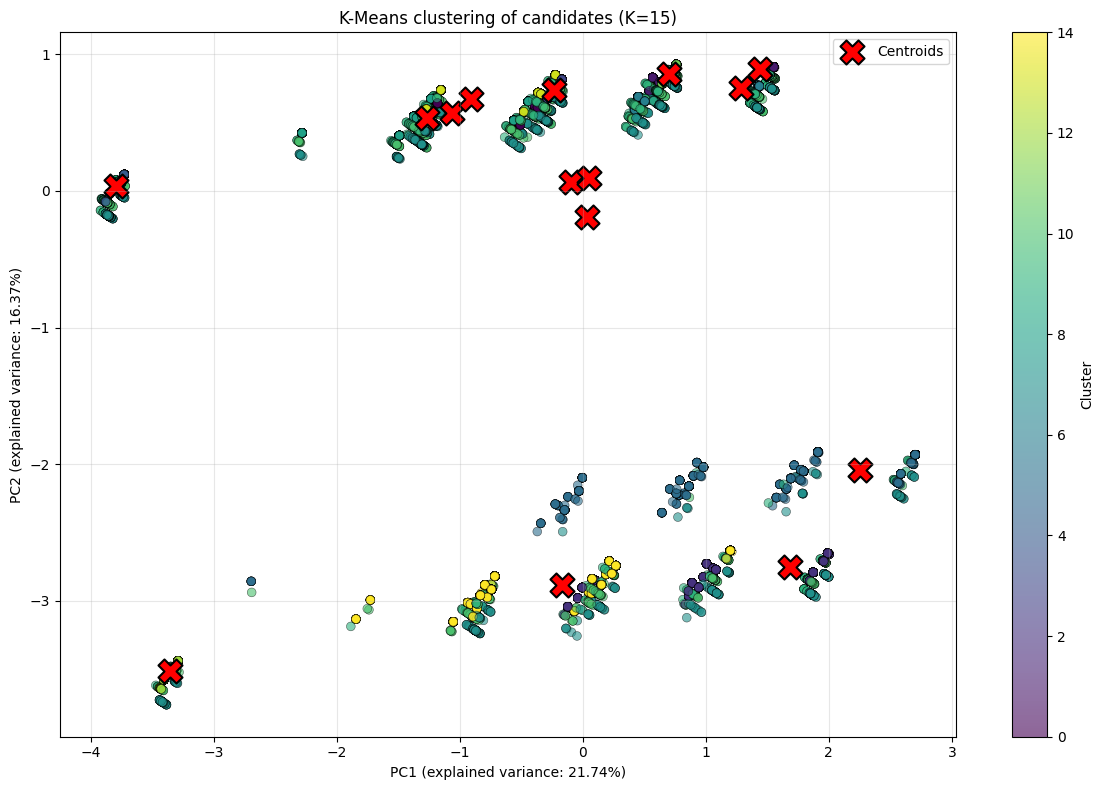

Total variance explained by PC1+PC2: 38.12%


In [11]:
print("Visualizing K-Means clusters with PCA (2D)...")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters_kmeans,
    cmap="viridis",
    alpha=0.6,
    s=40,
    edgecolors="black",
    linewidth=0.4,
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
plt.title(f"K-Means clustering of candidates (K={n_clusters})")
plt.grid(True, alpha=0.3)

# Plot centroids in PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker="X",
    s=300,
    c="red",
    edgecolors="black",
    linewidth=1.5,
    label="Centroids",
)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total variance explained by PC1+PC2: {pca.explained_variance_ratio_.sum():.2%}")

Profiling K-Means clusters (average feature values)...
                Sexe_Male  Voie_generale  Voie_technologique  \
Cluster_KMeans                                                 
0                    0.37           0.00                0.00   
1                    1.00           0.00                0.00   
2                    0.30           0.00                1.00   
3                    0.45           0.00                0.00   
4                    0.42           0.00                0.00   
5                    0.38           1.00                0.00   
6                    0.00           0.00                0.00   
7                    0.22           0.02                0.18   
8                    0.30           0.00                0.00   
9                    0.29           0.01                0.15   
10                   0.23           0.00                0.15   
11                   0.51           0.00                0.00   
12                   0.46           0.00         

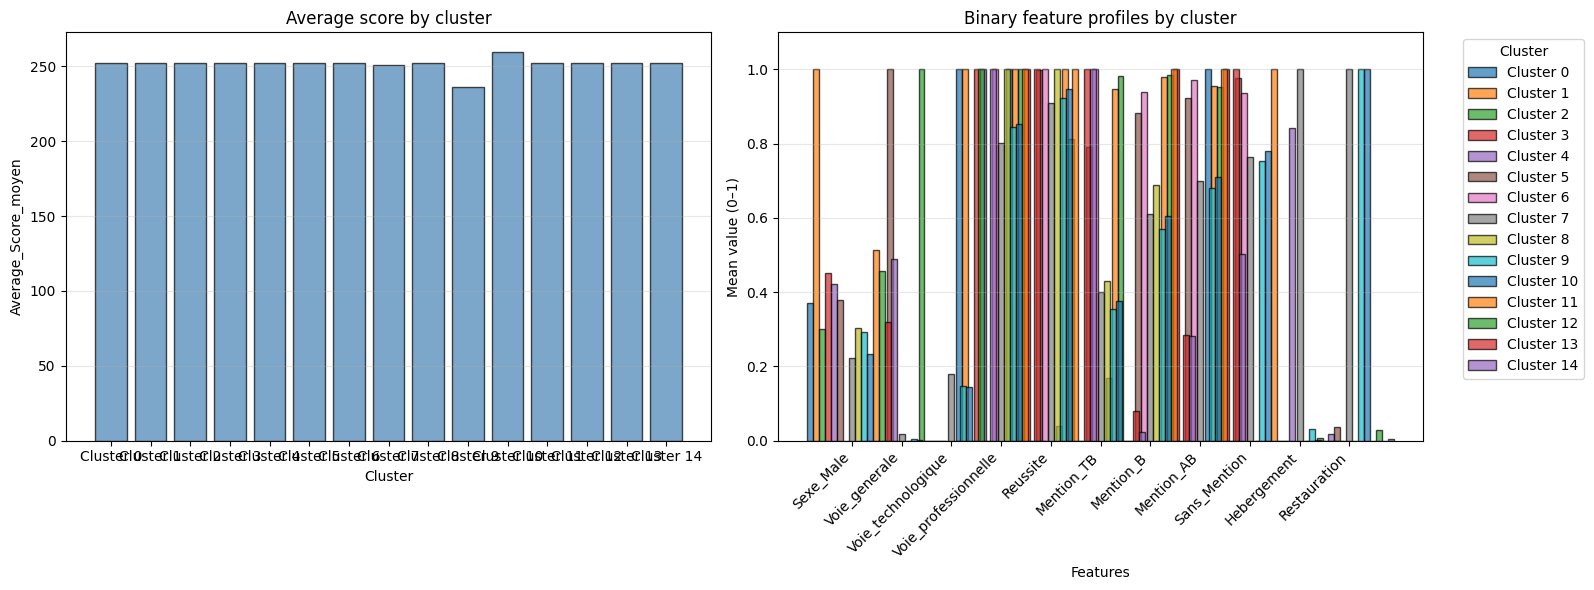

<Figure size 1400x800 with 0 Axes>

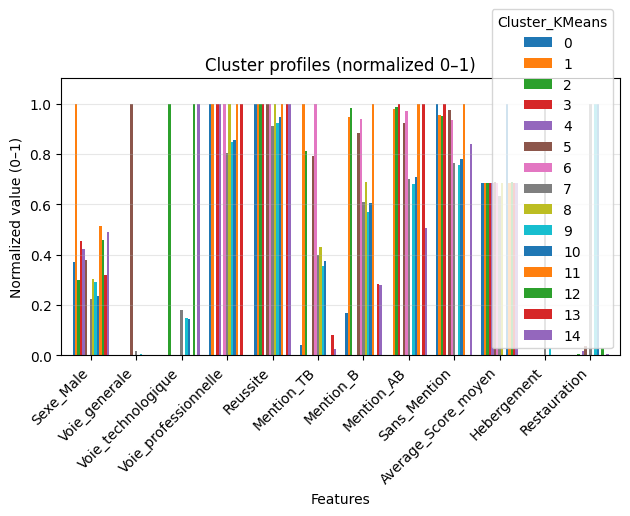

In [12]:
print("Profiling K-Means clusters (average feature values)...")

cluster_profiles_kmeans = df_clean.groupby("Cluster_KMeans")[features_manual].mean()
print(cluster_profiles_kmeans.round(2))

# Separate score and binary features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average score per cluster
axes[0].bar(
    range(len(cluster_profiles_kmeans)),
    cluster_profiles_kmeans["Average_Score_moyen"],
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
)
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Average_Score_moyen")
axes[0].set_title("Average score by cluster")
axes[0].set_xticks(range(len(cluster_profiles_kmeans)))
axes[0].set_xticklabels([f"Cluster {i}" for i in cluster_profiles_kmeans.index])
axes[0].grid(True, alpha=0.3, axis="y")

# Binary features
binary_features = [c for c in features_manual if c != "Average_Score_moyen"]
cluster_profiles_binary = cluster_profiles_kmeans[binary_features]

x = np.arange(len(cluster_profiles_binary.columns))
width = 0.12

for i, cluster_id in enumerate(cluster_profiles_binary.index):
    offset = (i - len(cluster_profiles_binary.index) / 2) * width + width / 2
    axes[1].bar(
        x + offset,
        cluster_profiles_binary.loc[cluster_id],
        width,
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        edgecolor="black",
    )

axes[1].set_xlabel("Features")
axes[1].set_ylabel("Mean value (0–1)")
axes[1].set_title("Binary feature profiles by cluster")
axes[1].set_xticks(x)
axes[1].set_xticklabels(binary_features, rotation=45, ha="right")
axes[1].set_ylim([0, 1.1])
axes[1].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Normalized view for all features
cluster_profiles_normalized = cluster_profiles_kmeans.copy()
for col in cluster_profiles_normalized.columns:
    col_min = cluster_profiles_normalized[col].min()
    col_max = cluster_profiles_normalized[col].max()
    if col_max > col_min:
        cluster_profiles_normalized[col] = (
            cluster_profiles_normalized[col] - col_min
        ) / (col_max - col_min)

plt.figure(figsize=(14, 8))
cluster_profiles_normalized.T.plot(kind="bar", width=0.8)
plt.title("Cluster profiles (normalized 0–1)")
plt.xlabel("Features")
plt.ylabel("Normalized value (0–1)")
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

In [13]:
print("Running hierarchical clustering (Ward linkage) on a sample...")

sample_size = min(5000, len(X_scaled))
if len(X_scaled) > sample_size:
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
    X_cah = X_scaled[sample_indices]
else:
    X_cah = X_scaled.copy()

print(f"CAH sample shape: {X_cah.shape}")

linkage_matrix = linkage(X_cah, method="ward")
print("Linkage matrix computed.")

Running hierarchical clustering (Ward linkage) on a sample...
CAH sample shape: (5000, 12)
Linkage matrix computed.


Visualizing hierarchical clustering dendrogram (truncated)...


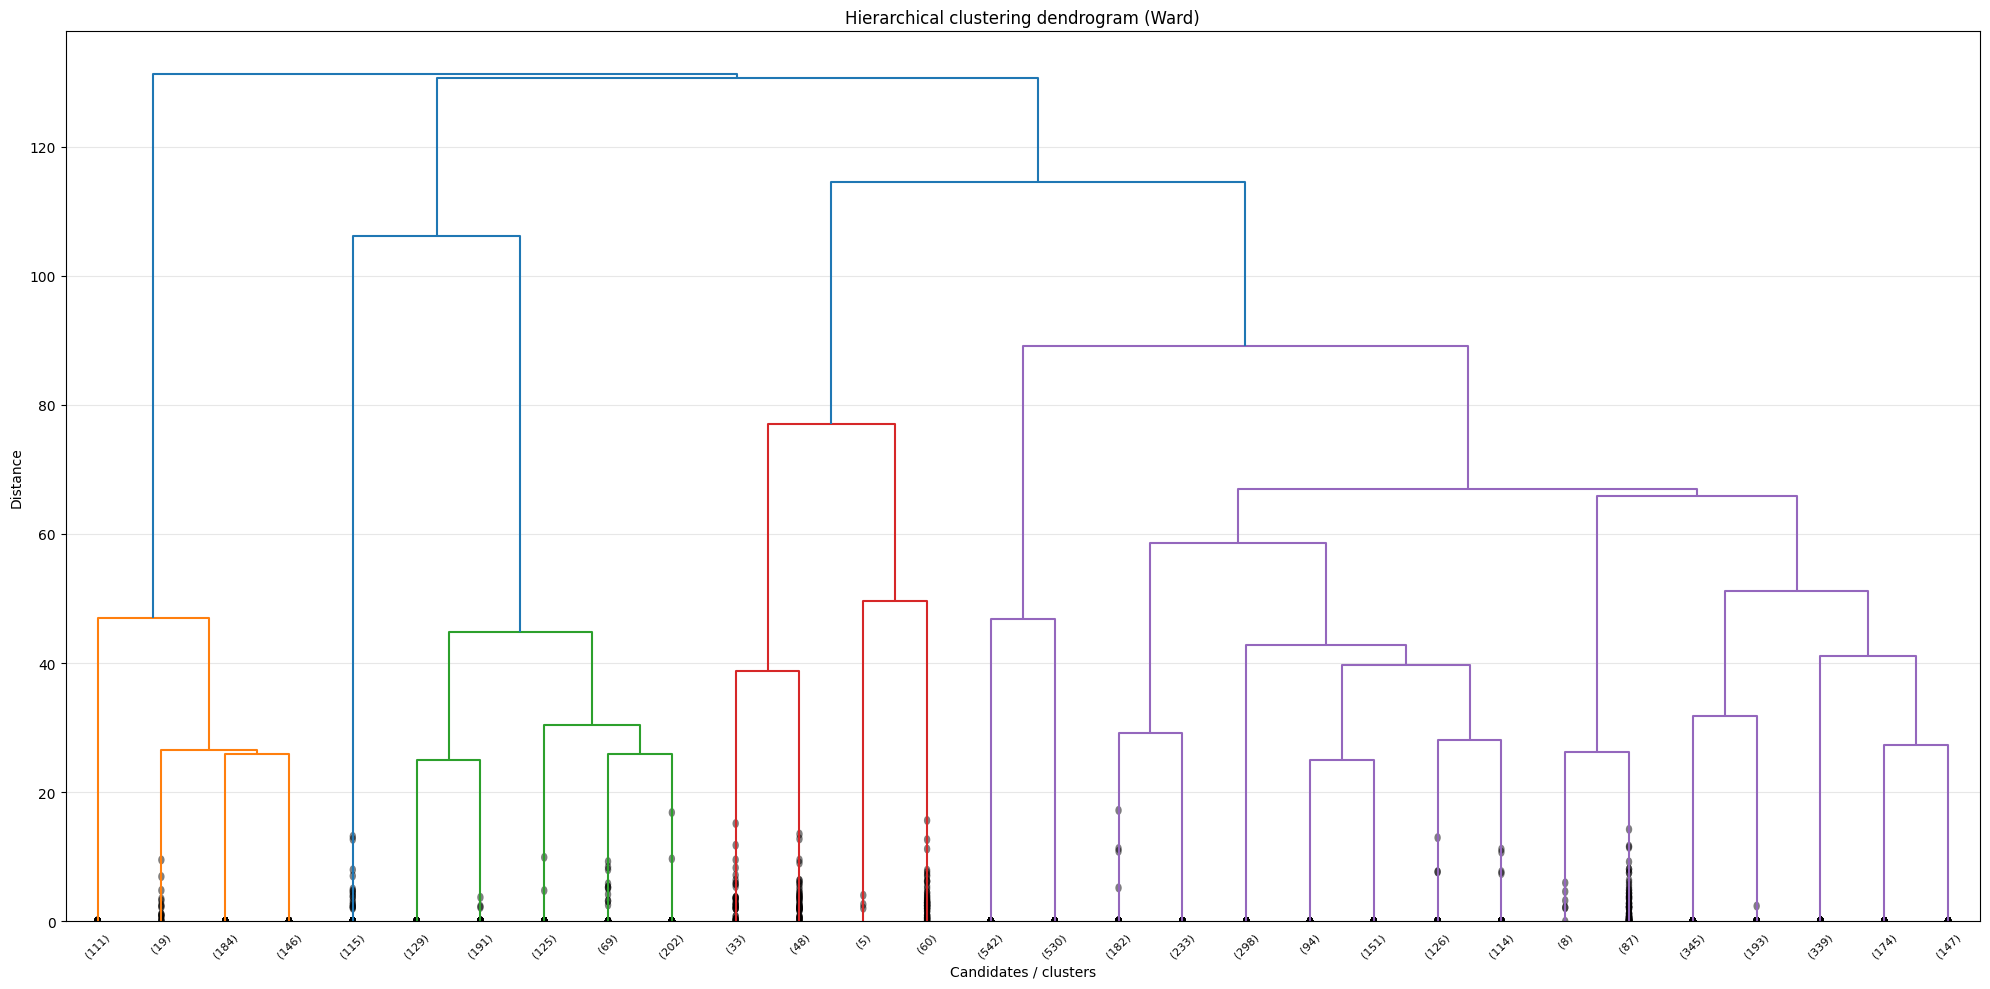

In [14]:
print("Visualizing hierarchical clustering dendrogram (truncated)...")

plt.figure(figsize=(20, 10))
dendrogram(
    linkage_matrix,
    truncate_mode="lastp",
    p=30,
    show_leaf_counts=True,
    leaf_font_size=8,
    show_contracted=True,
)
plt.title("Hierarchical clustering dendrogram (Ward)")
plt.xlabel("Candidates / clusters")
plt.ylabel("Distance")
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

In [15]:
print("Fitting hierarchical clustering with K equal to K-Means optimal K...")

n_samples = len(X_scaled)
sample_size = 5000

if n_samples > 10_000:
    np.random.seed(42)
    sample_indices = np.random.choice(n_samples, size=sample_size, replace=False)
    X_cah = X_scaled[sample_indices]
else:
    X_cah = X_scaled
    sample_indices = None

linkage_matrix = linkage(X_cah, method="ward")

cah = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
clusters_cah = cah.fit_predict(X_cah)

if len(X_cah) < len(X_scaled):
    # Hybrid mapping: use centroids from CAH sample as initialization for KMeans on full data
    centroids_cah = []
    for cluster_id in range(n_clusters):
        mask = clusters_cah == cluster_id
        if mask.sum() > 0:
            centroids_cah.append(X_cah[mask].mean(axis=0))
        else:
            centroids_cah.append(X_cah.mean(axis=0))

    centroids_cah = np.array(centroids_cah)

    kmeans_cah_mapper = KMeans(
        n_clusters=n_clusters,
        init=centroids_cah,
        n_init=1,
        random_state=42,
        max_iter=10,
    )
    clusters_cah_full = kmeans_cah_mapper.fit_predict(X_scaled)
    df_clean["Cluster_CAH"] = clusters_cah_full
else:
    df_clean["Cluster_CAH"] = clusters_cah

print("CAH cluster distribution:")
cluster_counts_cah = df_clean["Cluster_CAH"].value_counts().sort_index()
for cluster_id, count in cluster_counts_cah.items():
    pct = count / len(df_clean) * 100
    print(f"  Cluster {cluster_id}: {count:,} candidates ({pct:.1f}%)")

Fitting hierarchical clustering with K equal to K-Means optimal K...
CAH cluster distribution:
  Cluster 0: 30,328 candidates (12.6%)
  Cluster 1: 35,590 candidates (14.8%)
  Cluster 2: 3,870 candidates (1.6%)
  Cluster 3: 18,024 candidates (7.5%)
  Cluster 4: 26,417 candidates (11.0%)
  Cluster 5: 16,584 candidates (6.9%)
  Cluster 6: 16,189 candidates (6.7%)
  Cluster 7: 3,960 candidates (1.6%)
  Cluster 8: 4,638 candidates (1.9%)
  Cluster 9: 4,909 candidates (2.0%)
  Cluster 10: 18,614 candidates (7.7%)
  Cluster 11: 566 candidates (0.2%)
  Cluster 12: 5,058 candidates (2.1%)
  Cluster 13: 27,285 candidates (11.3%)
  Cluster 14: 28,565 candidates (11.9%)


Visualizing CAH clusters using the same PCA projection as K-Means...


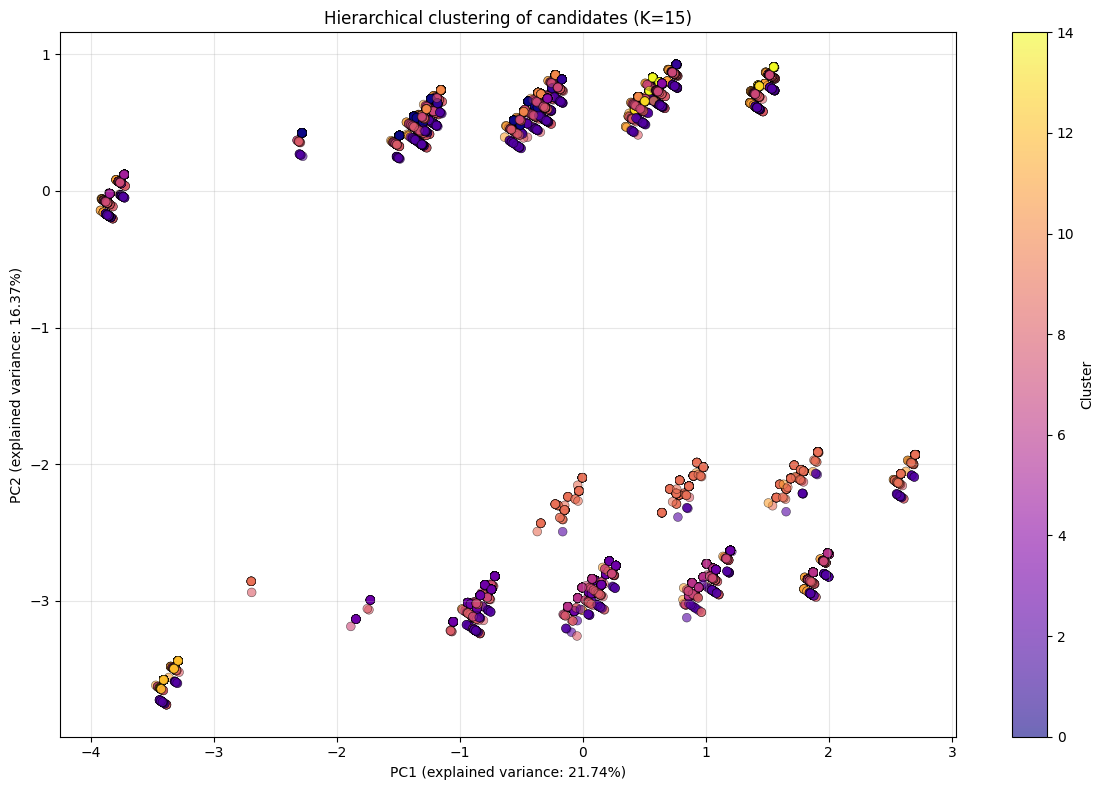

In [16]:
print("Visualizing CAH clusters using the same PCA projection as K-Means...")

if "pca" in locals():
    X_pca_cah = pca.transform(X_scaled)
else:
    pca = PCA(n_components=2, random_state=42)
    X_pca_cah = pca.fit_transform(X_scaled)

clusters_cah_viz = df_clean["Cluster_CAH"].values

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca_cah[:, 0],
    X_pca_cah[:, 1],
    c=clusters_cah_viz,
    cmap="plasma",
    alpha=0.6,
    s=40,
    edgecolors="black",
    linewidth=0.4,
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
plt.title(f"Hierarchical clustering of candidates (K={n_clusters})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
print("Running DBSCAN over a grid of hyperparameters...")

eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
min_samples_values = [5, 10, 15, 20]

best_eps = None
best_min_samples = None
best_score = -1
best_n_clusters = 0
best_labels = None
results_dbscan = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters_db >= 2:
            mask = labels != -1
            if mask.sum() > 0:
                score = silhouette_score(X_scaled[mask], labels[mask])
                results_dbscan.append(
                    {
                        "eps": eps,
                        "min_samples": min_samples,
                        "n_clusters": n_clusters_db,
                        "n_noise": n_noise,
                        "silhouette": score,
                    }
                )
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_n_clusters = n_clusters_db
                    best_labels = labels.copy()

if best_labels is not None:
    print("Best DBSCAN parameters:")
    print(f"  eps={best_eps}, min_samples={best_min_samples}")
    print(f"  clusters={best_n_clusters}, noise points={list(best_labels).count(-1):,}")
    print(f"  silhouette={best_score:.3f}")

    dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    clusters_dbscan = dbscan_final.fit_predict(X_scaled)
    df_clean["Cluster_DBSCAN"] = clusters_dbscan

    mask = clusters_dbscan != -1
    if mask.sum() > 0:
        silhouette_dbscan = silhouette_score(X_scaled[mask], clusters_dbscan[mask])
        davies_bouldin_dbscan = davies_bouldin_score(X_scaled[mask], clusters_dbscan[mask])
        calinski_harabasz_dbscan = calinski_harabasz_score(X_scaled[mask], clusters_dbscan[mask])

        print("DBSCAN quality metrics (without noise points):")
        print(f"  Silhouette: {silhouette_dbscan:.3f}")
        print(f"  Davies-Bouldin: {davies_bouldin_dbscan:.3f}")
        print(f"  Calinski-Harabasz: {calinski_harabasz_dbscan:.2f}")

    cluster_counts_dbscan = pd.Series(clusters_dbscan).value_counts().sort_index()
    print("DBSCAN cluster distribution:")
    for cluster_id, count in cluster_counts_dbscan.items():
        pct = count / len(df_clean) * 100
        if cluster_id == -1:
            print(f"  Noise (outliers): {count:,} candidates ({pct:.1f}%)")
        else:
            print(f"  Cluster {cluster_id}: {count:,} candidates ({pct:.1f}%)")

    if results_dbscan:
        results_df = pd.DataFrame(results_dbscan)
        print("\nTop 10 DBSCAN parameter settings by silhouette:")
        print(results_df.sort_values("silhouette", ascending=False).head(10).to_string(index=False))
else:
    print("No valid DBSCAN configuration produced at least two clusters.")
    clusters_dbscan = np.full(len(X_scaled), -1)
    df_clean["Cluster_DBSCAN"] = clusters_dbscan

Running DBSCAN over a grid of hyperparameters...
Best DBSCAN parameters:
  eps=0.3, min_samples=20
  clusters=178, noise points=6,630
  silhouette=0.980
DBSCAN quality metrics (without noise points):
  Silhouette: 0.980
  Davies-Bouldin: 0.431
  Calinski-Harabasz: 201696.41
DBSCAN cluster distribution:
  Noise (outliers): 6,630 candidates (2.8%)
  Cluster 0: 13,913 candidates (5.8%)
  Cluster 1: 9,380 candidates (3.9%)
  Cluster 2: 9,908 candidates (4.1%)
  Cluster 3: 4,929 candidates (2.0%)
  Cluster 4: 3,110 candidates (1.3%)
  Cluster 5: 24,711 candidates (10.3%)
  Cluster 6: 2,909 candidates (1.2%)
  Cluster 7: 16,498 candidates (6.9%)
  Cluster 8: 7,378 candidates (3.1%)
  Cluster 9: 809 candidates (0.3%)
  Cluster 10: 1,101 candidates (0.5%)
  Cluster 11: 741 candidates (0.3%)
  Cluster 12: 2,448 candidates (1.0%)
  Cluster 13: 1,750 candidates (0.7%)
  Cluster 14: 914 candidates (0.4%)
  Cluster 15: 31 candidates (0.0%)
  Cluster 16: 1,855 candidates (0.8%)
  Cluster 17: 148 can

Visualizing DBSCAN clusters in PCA space and cluster size distribution...
Total DBSCAN clusters (excluding noise): 178
Number of outliers: 6,630 (2.8%)
Top 15 clusters by size:
   1. Cluster 112: 25,212 candidates (10.5%)
   2. Cluster 5: 24,711 candidates (10.3%)
   3. Cluster 107: 17,459 candidates (7.3%)
   4. Cluster 7: 16,498 candidates (6.9%)
   5. Cluster 0: 13,913 candidates (5.8%)
   6. Cluster 2: 9,908 candidates (4.1%)
   7. Cluster 29: 9,383 candidates (3.9%)
   8. Cluster 1: 9,380 candidates (3.9%)
   9. Cluster 115: 8,180 candidates (3.4%)
  10. Cluster 111: 8,146 candidates (3.4%)
  11. Cluster 8: 7,378 candidates (3.1%)
  12. Cluster 110: 6,929 candidates (2.9%)
  13. Cluster 135: 5,680 candidates (2.4%)
  14. Cluster 3: 4,929 candidates (2.0%)
  15. Cluster 27: 3,369 candidates (1.4%)


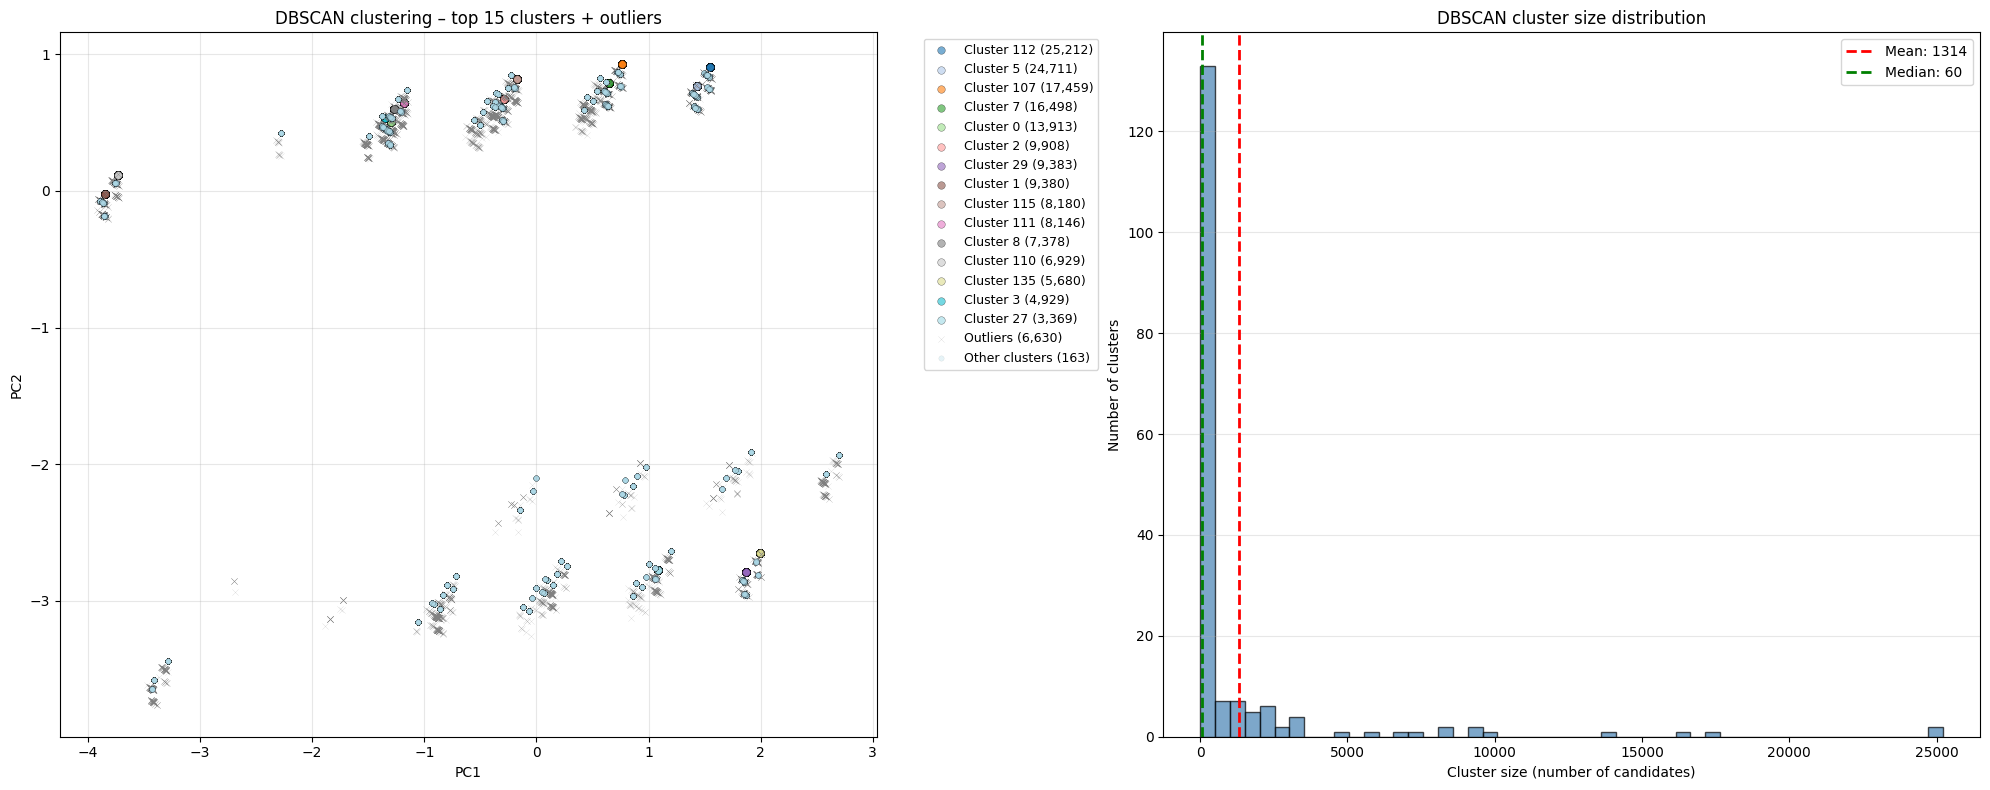

DBSCAN cluster size statistics:
  Mean: 1314
  Median: 60
  Min: 13
  Max: 25212
  Std: 3671


In [18]:
print("Visualizing DBSCAN clusters in PCA space and cluster size distribution...")

if "Cluster_DBSCAN" in df_clean.columns:
    clusters_dbscan = df_clean["Cluster_DBSCAN"].values
    cluster_counts = pd.Series(clusters_dbscan).value_counts().sort_values(ascending=False)

    n_clusters_dbscan = len(cluster_counts) - (1 if -1 in cluster_counts.index else 0)
    n_outliers = cluster_counts.get(-1, 0)

    print(f"Total DBSCAN clusters (excluding noise): {n_clusters_dbscan}")
    print(f"Number of outliers: {n_outliers:,} ({n_outliers/len(df_clean)*100:.1f}%)")

    top_n_clusters = 15
    top_clusters = cluster_counts[cluster_counts.index != -1].head(top_n_clusters).index.tolist()

    print(f"Top {top_n_clusters} clusters by size:")
    for i, cluster_id in enumerate(top_clusters, 1):
        count = cluster_counts[cluster_id]
        pct = count / len(df_clean) * 100
        print(f"  {i:2d}. Cluster {cluster_id}: {count:,} candidates ({pct:.1f}%)")

    if "pca" in locals():
        X_pca_dbscan = pca.transform(X_scaled)
    else:
        pca = PCA(n_components=2, random_state=42)
        X_pca_dbscan = pca.fit_transform(X_scaled)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left: main clusters + noise
    ax1 = axes[0]
    colors_top = plt.cm.tab20(np.linspace(0, 1, len(top_clusters)))

    for i, cluster_id in enumerate(top_clusters):
        mask = clusters_dbscan == cluster_id
        if mask.sum() > 0:
            ax1.scatter(
                X_pca_dbscan[mask, 0],
                X_pca_dbscan[mask, 1],
                c=[colors_top[i]],
                label=f"Cluster {cluster_id} ({cluster_counts[cluster_id]:,})",
                alpha=0.6,
                s=30,
                edgecolors="black",
                linewidth=0.3,
            )

    mask_outliers = clusters_dbscan == -1
    if mask_outliers.sum() > 0:
        ax1.scatter(
            X_pca_dbscan[mask_outliers, 0],
            X_pca_dbscan[mask_outliers, 1],
            c="gray",
            label=f"Outliers ({n_outliers:,})",
            alpha=0.4,
            s=20,
            edgecolors="black",
            linewidth=0.2,
            marker="x",
        )

    other_clusters = [c for c in cluster_counts.index if c != -1 and c not in top_clusters]
    if len(other_clusters) > 0:
        mask_others = np.isin(clusters_dbscan, other_clusters)
        if mask_others.sum() > 0:
            ax1.scatter(
                X_pca_dbscan[mask_others, 0],
                X_pca_dbscan[mask_others, 1],
                c="lightblue",
                label=f"Other clusters ({len(other_clusters)})",
                alpha=0.3,
                s=15,
                edgecolors="black",
                linewidth=0.1,
            )

    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_title(f"DBSCAN clustering – top {top_n_clusters} clusters + outliers")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Right: histogram of cluster sizes
    ax2 = axes[1]
    cluster_sizes = cluster_counts[cluster_counts.index != -1].values

    ax2.hist(cluster_sizes, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
    ax2.axvline(x=cluster_sizes.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {cluster_sizes.mean():.0f}")
    ax2.axvline(x=np.median(cluster_sizes), color="green", linestyle="--", linewidth=2, label=f"Median: {np.median(cluster_sizes):.0f}")

    ax2.set_xlabel("Cluster size (number of candidates)")
    ax2.set_ylabel("Number of clusters")
    ax2.set_title("DBSCAN cluster size distribution")
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

    print("DBSCAN cluster size statistics:")
    print(f"  Mean: {cluster_sizes.mean():.0f}")
    print(f"  Median: {np.median(cluster_sizes):.0f}")
    print(f"  Min: {cluster_sizes.min():.0f}")
    print(f"  Max: {cluster_sizes.max():.0f}")
    print(f"  Std: {cluster_sizes.std():.0f}")
else:
    print("DBSCAN has not been run yet.")

Creating boxplots of key features by K-Means cluster...
Number of clusters shown (>=1% of data): 15


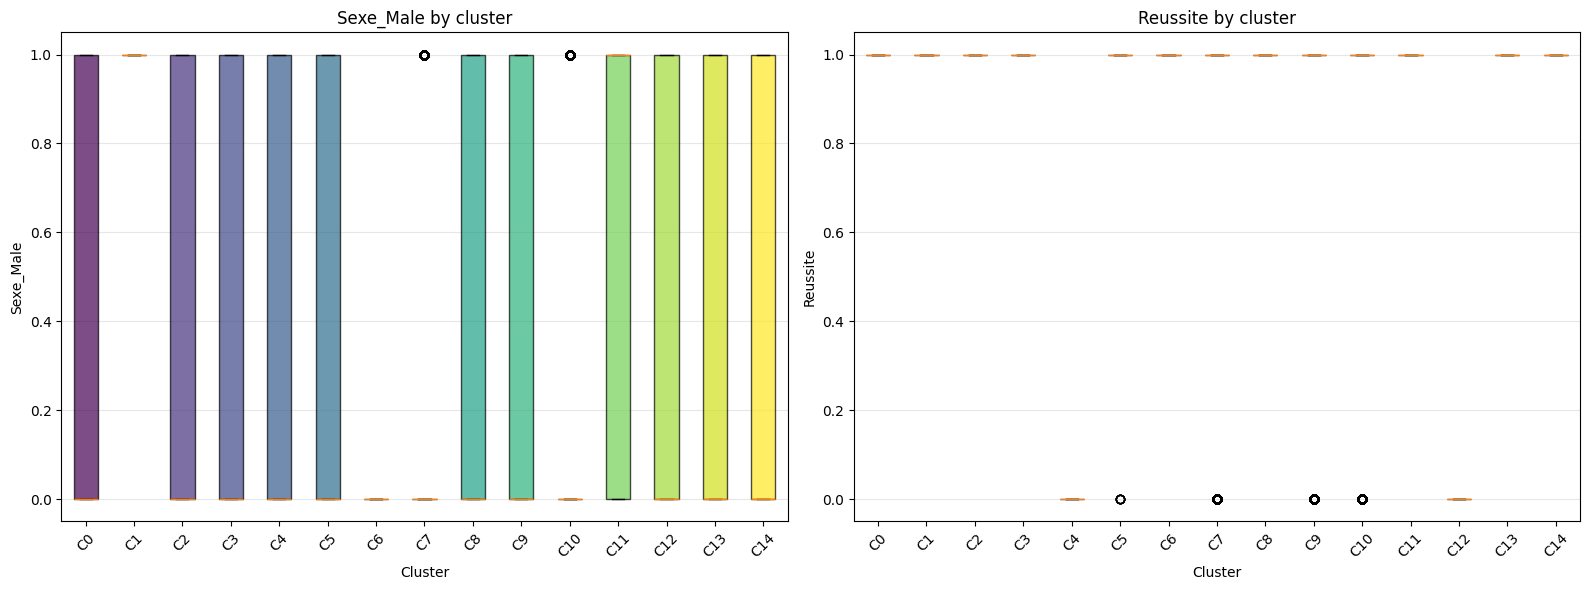

In [19]:
print("Creating boxplots of key features by K-Means cluster...")

variables = ["Sexe_Male", "Reussite"]
cluster_counts = df_clean["Cluster_KMeans"].value_counts()
min_samples = len(df_clean) * 0.01
significant_clusters = sorted(cluster_counts[cluster_counts >= min_samples].index.tolist())

print(f"Number of clusters shown (>=1% of data): {len(significant_clusters)}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, feature in enumerate(variables):
    data = [df_clean[df_clean["Cluster_KMeans"] == c][feature].values for c in significant_clusters]
    labels = [f"C{c}" for c in significant_clusters]

    bp = axes[idx].boxplot(data, labels=labels, patch_artist=True)

    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[idx].set_title(f"{feature} by cluster")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel(feature)
    axes[idx].tick_params(axis="x", rotation=45)
    axes[idx].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

Computing t-SNE and (optionally) UMAP embeddings...


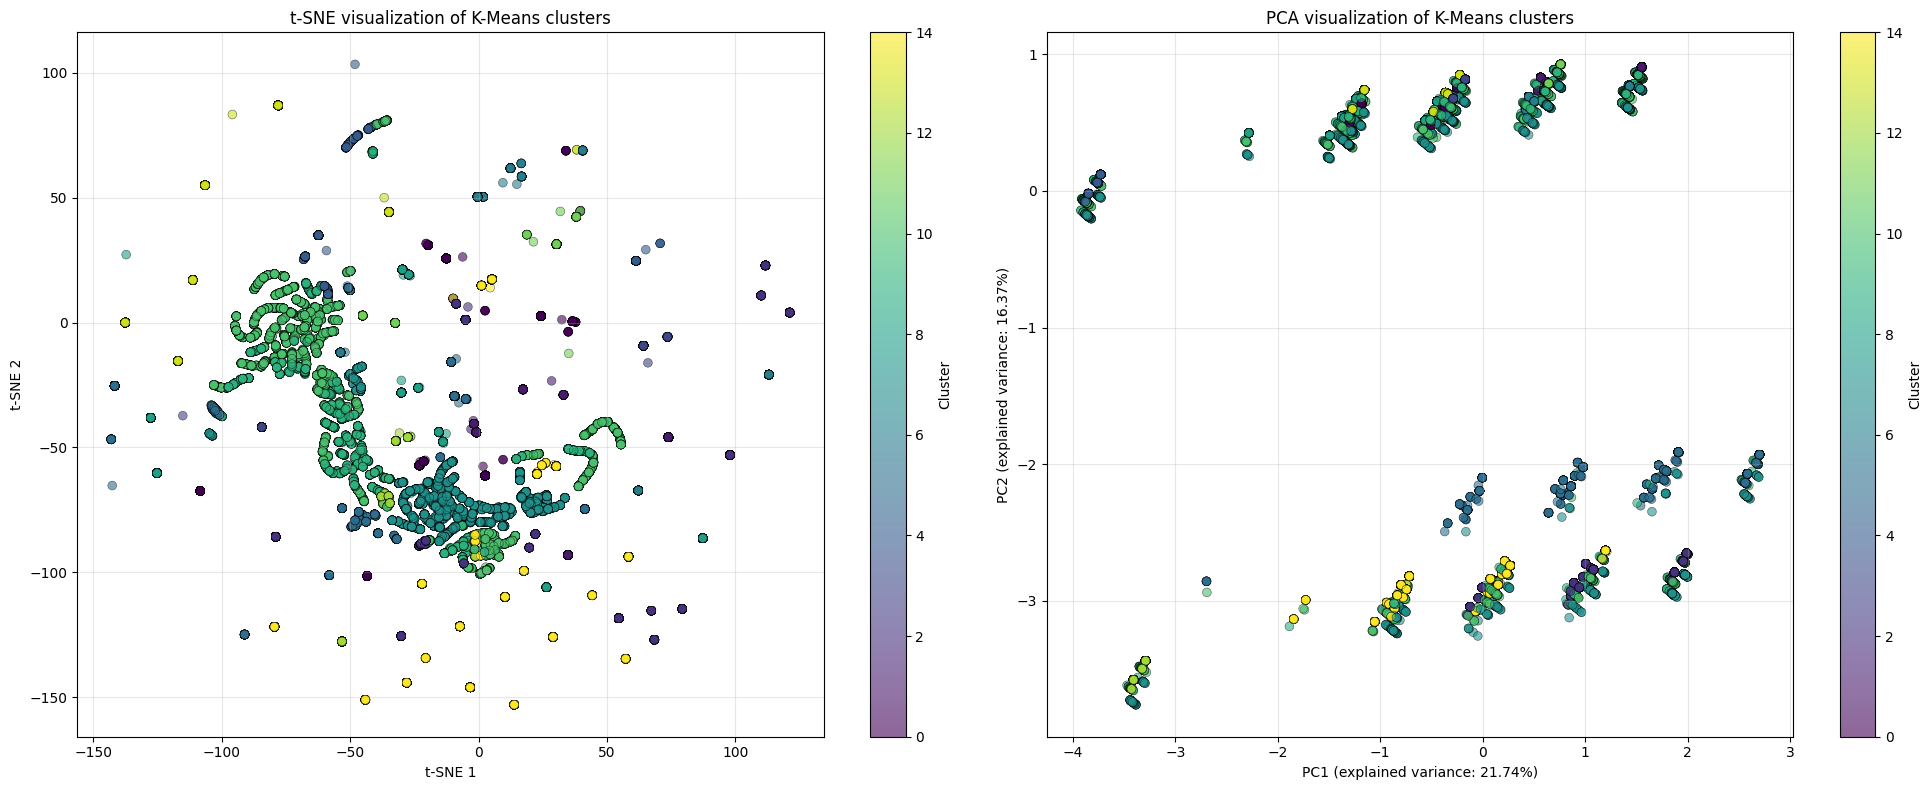

UMAP is not installed. Install with `pip install umap-learn` to enable this section.


In [20]:
print("Computing t-SNE and (optionally) UMAP embeddings...")

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

scatter1 = axes[0].scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=clusters_kmeans,
    cmap="viridis",
    alpha=0.6,
    s=40,
    edgecolors="black",
    linewidth=0.4,
)
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].set_title("t-SNE visualization of K-Means clusters")
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label="Cluster")

scatter2 = axes[1].scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters_kmeans,
    cmap="viridis",
    alpha=0.6,
    s=40,
    edgecolors="black",
    linewidth=0.4,
)
axes[1].set_xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
axes[1].set_ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
axes[1].set_title("PCA visualization of K-Means clusters")
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label="Cluster")

plt.tight_layout()
plt.show()

if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = reducer.fit_transform(X_scaled)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=clusters_kmeans,
        cmap="viridis",
        alpha=0.6,
        s=40,
        edgecolors="black",
        linewidth=0.4,
    )
    plt.colorbar(scatter, label="Cluster")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title("UMAP visualization of K-Means clusters")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("UMAP is not installed. Install with `pip install umap-learn` to enable this section.")

Comparing clustering algorithms (K-Means, CAH, DBSCAN)...

Overall clustering metrics:
 Method   K Silhouette Davies-Bouldin Calinski-Harabasz
K-Means  15   0.550095       0.974434      67777.189461
    CAH  15        N/A            N/A               N/A
 DBSCAN 178   0.979605       0.430559     201696.411517

Adjusted Rand Index (ARI) between methods...

ARI matrix (1 = identical, 0 = random):
         K-Means    CAH  DBSCAN
K-Means    1.000  0.692   0.653
CAH        0.692  1.000   0.617
DBSCAN     0.653  0.617   1.000


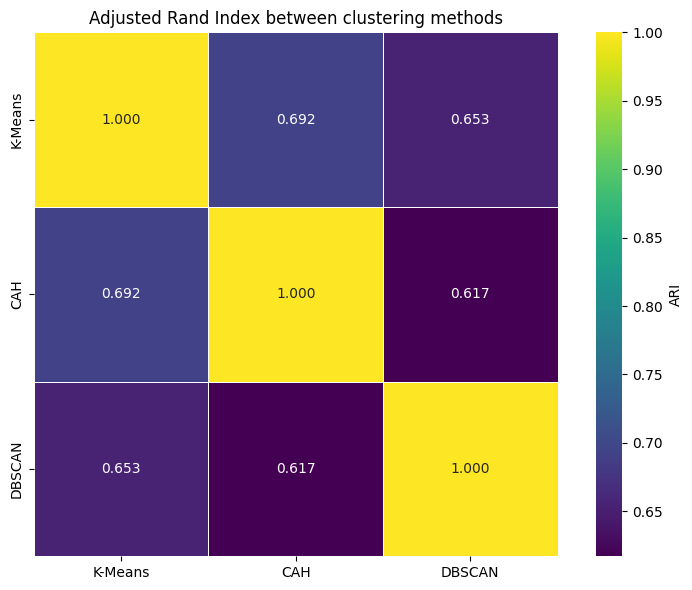


Summary of best methods by metric:
  Highest Silhouette: DBSCAN (0.980)
  Lowest Davies-Bouldin: DBSCAN (0.431)
  Highest Calinski-Harabasz: DBSCAN (201696.41)


In [21]:
print("Comparing clustering algorithms (K-Means, CAH, DBSCAN)...")

# Collect metrics where available
comparison_data = {
    "Method": ["K-Means", "CAH"],
    "K": [n_clusters, n_clusters],
    "Silhouette": [silhouette_kmeans, silhouette_cah if "silhouette_cah" in locals() else "N/A"],
    "Davies-Bouldin": [
        davies_bouldin_kmeans,
        davies_bouldin_cah if "davies_bouldin_cah" in locals() else "N/A",
    ],
    "Calinski-Harabasz": [
        calinski_harabasz_kmeans,
        calinski_harabasz_cah if "calinski_harabasz_cah" in locals() else "N/A",
    ],
}

# Add DBSCAN if metrics exist
if "silhouette_dbscan" in locals():
    comparison_data["Method"].append("DBSCAN")
    comparison_data["K"].append(best_n_clusters if "best_n_clusters" in locals() else "N/A")
    comparison_data["Silhouette"].append(silhouette_dbscan)
    comparison_data["Davies-Bouldin"].append(davies_bouldin_dbscan)
    comparison_data["Calinski-Harabasz"].append(calinski_harabasz_dbscan)

# Add GMM if you later compute it
if "silhouette_gmm" in locals():
    comparison_data["Method"].append("GMM")
    comparison_data["K"].append(n_components_gmm)
    comparison_data["Silhouette"].append(silhouette_gmm)
    comparison_data["Davies-Bouldin"].append(davies_bouldin_gmm)
    comparison_data["Calinski-Harabasz"].append(calinski_harabasz_gmm)

comparison_df = pd.DataFrame(comparison_data)
print("\nOverall clustering metrics:")
print(comparison_df.to_string(index=False))

# Adjusted Rand Index matrix between methods
print("\nAdjusted Rand Index (ARI) between methods...")

methods = ["K-Means", "CAH"]
labels_dict = {
    "K-Means": df_clean["Cluster_KMeans"].values,
    "CAH": df_clean["Cluster_CAH"].values,
}

if "Cluster_DBSCAN" in df_clean.columns:
    methods.append("DBSCAN")
    labels_dict["DBSCAN"] = df_clean["Cluster_DBSCAN"].values

if "Cluster_GMM" in df_clean.columns:
    methods.append("GMM")
    labels_dict["GMM"] = df_clean["Cluster_GMM"].values

ari_matrix = np.zeros((len(methods), len(methods)))
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i == j:
            ari_matrix[i, j] = 1.0
        else:
            labels1 = labels_dict[m1]
            labels2 = labels_dict[m2]

            if m1 == "DBSCAN" or m2 == "DBSCAN":
                mask = (labels1 != -1) & (labels2 != -1)
                if mask.sum() > 0:
                    ari_matrix[i, j] = adjusted_rand_score(labels1[mask], labels2[mask])
                else:
                    ari_matrix[i, j] = 0
            else:
                ari_matrix[i, j] = adjusted_rand_score(labels1, labels2)

ari_df = pd.DataFrame(ari_matrix, index=methods, columns=methods)
print("\nARI matrix (1 = identical, 0 = random):")
print(ari_df.round(3))

plt.figure(figsize=(8, 6))
sns.heatmap(ari_df, annot=True, fmt=".3f", cmap="viridis", cbar_kws={"label": "ARI"}, square=True, linewidths=0.5)
plt.title("Adjusted Rand Index between clustering methods")
plt.tight_layout()
plt.show()

print("\nSummary of best methods by metric:")
if len(comparison_df) > 0:
    valid_sil = comparison_df[comparison_df["Silhouette"] != "N/A"]
    if not valid_sil.empty:
        idx_best_sil = valid_sil["Silhouette"].astype(float).idxmax()
        print(f"  Highest Silhouette: {comparison_df.loc[idx_best_sil, 'Method']} ({comparison_df.loc[idx_best_sil, 'Silhouette']:.3f})")

    valid_db = comparison_df[comparison_df["Davies-Bouldin"] != "N/A"]
    if not valid_db.empty:
        idx_best_db = valid_db["Davies-Bouldin"].astype(float).idxmin()
        print(f"  Lowest Davies-Bouldin: {comparison_df.loc[idx_best_db, 'Method']} ({comparison_df.loc[idx_best_db, 'Davies-Bouldin']:.3f})")

    valid_ch = comparison_df[comparison_df["Calinski-Harabasz"] != "N/A"]
    if not valid_ch.empty:
        idx_best_ch = valid_ch["Calinski-Harabasz"].astype(float).idxmax()
        print(f"  Highest Calinski-Harabasz: {comparison_df.loc[idx_best_ch, 'Method']} ({comparison_df.loc[idx_best_ch, 'Calinski-Harabasz']:.2f})")

## Part 11 – Association Rules on Candidates (Apriori & FP-Growth)

### 11.1 Data Preparation

In [22]:
print("Preparing candidate data for association rule mining (binary transaction matrix)...")

query_candidates_assoc = query_candidates  # reuse the same SQL as before

try:
    df_candidates = execute_query_with_retry(query_candidates_assoc, conn)
    print(f"Association-rule base: {df_candidates.shape[0]:,} rows, {df_candidates.shape[1]} columns.")
except Exception as e:
    print(f"Error while loading candidates for association rules: {e}")
    df_candidates = pd.DataFrame()

if len(df_candidates) > 0:
    df_candidates_clean = df_candidates.copy()

    # Sex
    if "sexe" in df_candidates_clean.columns:
        df_candidates_clean["Sexe_Male"] = (
            df_candidates_clean["sexe"].str.upper().str.strip().str.contains("M", na=False)
        ).astype(int)
        df_candidates_clean["Sexe_Female"] = (
            df_candidates_clean["sexe"].str.upper().str.strip().str.contains("F", na=False)
        ).astype(int)

    # Outcomes
    df_candidates_clean["Reussite"] = (df_candidates_clean["nb_admis_totaux"] > 0).astype(int)
    df_candidates_clean["Mention_TB"] = (df_candidates_clean["nb_admis_mention_TB"] > 0).astype(int)
    df_candidates_clean["Mention_TB_Felicitations"] = (
        df_candidates_clean["nb_admis_mention_TB_felicitations"] > 0
    ).astype(int)
    df_candidates_clean["Mention_B"] = (df_candidates_clean["nb_admis_mention_B"] > 0).astype(int)
    df_candidates_clean["Mention_AB"] = (df_candidates_clean["nb_admis_mention_AB"] > 0).astype(int)
    df_candidates_clean["Sans_Mention"] = (df_candidates_clean["nb_admis_sans_mention"] > 0).astype(int)

    # Track
    if "voie" in df_candidates_clean.columns:
        df_candidates_clean["Voie_generale"] = df_candidates_clean["voie"].str.contains(
            "general", case=False, na=False
        ).astype(int)
        df_candidates_clean["Voie_technologique"] = df_candidates_clean["voie"].str.contains(
            "technologique", case=False, na=False
        ).astype(int)
        df_candidates_clean["Voie_professionnelle"] = df_candidates_clean["voie"].str.contains(
            "professionnel", case=False, na=False
        ).astype(int)

    # Series
    if "serie" in df_candidates_clean.columns:
        main_series = ["S", "ES", "L", "STI", "STL", "STD2A", "STMG", "ST2S", "STAV"]
        for serie in main_series:
            col_name = f"Serie_{serie}"
            df_candidates_clean[col_name] = df_candidates_clean["serie"].str.contains(
                serie, case=False, na=False
            ).astype(int)

    # Establishment binary features
    binary_cols_etab = ["Hebergement", "Restauration", "Section_internationale", "GRETA", "PIAL"]
    for col in binary_cols_etab:
        if col in df_candidates_clean.columns:
            df_candidates_clean[col] = (
                pd.to_numeric(df_candidates_clean[col], errors="coerce").fillna(0).astype(int)
            )

    cols_for_assoc = [
        "Sexe_Male",
        "Sexe_Female",
        "Voie_generale",
        "Voie_technologique",
        "Voie_professionnelle",
        "Hebergement",
        "Restauration",
        "Section_internationale",
        "Reussite",
        "Mention_TB",
        "Mention_TB_Felicitations",
        "Mention_B",
        "Mention_AB",
    ]

    serie_cols = [c for c in df_candidates_clean.columns if c.startswith("Serie_")]
    cols_for_assoc.extend(serie_cols)
    cols_for_assoc = [c for c in cols_for_assoc if c in df_candidates_clean.columns]

    df_transactions = df_candidates_clean[cols_for_assoc].copy()
    df_transactions = (df_transactions > 0).astype(int)

    print(f"Association transaction matrix: {df_transactions.shape[0]:,} rows, {df_transactions.shape[1]} binary items.")
    print("Columns used:")
    for i, col in enumerate(df_transactions.columns, 1):
        print(f"  {i}. {col}")
else:
    df_transactions = pd.DataFrame()
    print("No candidate data available for association rules.")

Preparing candidate data for association rule mining (binary transaction matrix)...
  25,000 rows loaded...
  50,000 rows loaded...
  75,000 rows loaded...
  100,000 rows loaded...
  125,000 rows loaded...
  150,000 rows loaded...
  175,000 rows loaded...
  200,000 rows loaded...
  225,000 rows loaded...
Loaded candidate data: 240,597 rows, 24 columns.
Association-rule base: 240,597 rows, 24 columns.
Association transaction matrix: 240,597 rows, 22 binary items.
Columns used:
  1. Sexe_Male
  2. Sexe_Female
  3. Voie_generale
  4. Voie_technologique
  5. Voie_professionnelle
  6. Hebergement
  7. Restauration
  8. Section_internationale
  9. Reussite
  10. Mention_TB
  11. Mention_TB_Felicitations
  12. Mention_B
  13. Mention_AB
  14. Serie_S
  15. Serie_ES
  16. Serie_L
  17. Serie_STI
  18. Serie_STL
  19. Serie_STD2A
  20. Serie_STMG
  21. Serie_ST2S
  22. Serie_STAV


In [23]:
print("Running Apriori to find frequent itemsets and association rules...")

# Parameters shared across Apriori and FP-Growth
min_support = 0.05        # 5%
min_confidence = 0.60     # 60%
min_lift = 1.20

print("Parameters:")
print(f"  min_support = {min_support} ({min_support*100:.1f}%)")
print(f"  min_confidence = {min_confidence} ({min_confidence*100:.1f}%)")
print(f"  min_lift = {min_lift}")

if not df_transactions.empty:
    frequent_itemsets_apriori = apriori(
        df_transactions,
        min_support=min_support,
        use_colnames=True,
        max_len=3,
    )

    print(f"Frequent itemsets found with Apriori: {len(frequent_itemsets_apriori)}")
    if len(frequent_itemsets_apriori) > 0:
        top_itemsets = frequent_itemsets_apriori.nlargest(10, "support")
        print("Top 10 itemsets by support:")
        for _, row in top_itemsets.iterrows():
            items = ", ".join(sorted(list(row["itemsets"])))
            print(f"  {{{items}}}: support={row['support']:.3f} ({row['support']*100:.1f}%)")

    # Extract rules from Apriori itemsets
    rules_apriori = association_rules(
        frequent_itemsets_apriori,
        metric="confidence",
        min_threshold=min_confidence,
    )
    rules_apriori = rules_apriori[rules_apriori["lift"] >= min_lift]

    print(f"Total Apriori rules after filtering by confidence and lift: {len(rules_apriori)}")
    if len(rules_apriori) > 0:
        top_rules = rules_apriori.nlargest(10, "lift")
        print("Top 10 Apriori rules by lift:")
        for _, row in top_rules.iterrows():
            antecedents = ", ".join(sorted(list(row["antecedents"])))
            consequents = ", ".join(sorted(list(row["consequents"])))
            print(
                f"  IF {{{antecedents}}} THEN {{{consequents}}} | "
                f"support={row['support']:.3f}, confidence={row['confidence']:.3f}, lift={row['lift']:.3f}"
            )
else:
    frequent_itemsets_apriori = pd.DataFrame()
    rules_apriori = pd.DataFrame()
    print("Skipping Apriori: transaction matrix is empty.")

Running Apriori to find frequent itemsets and association rules...
Parameters:
  min_support = 0.05 (5.0%)
  min_confidence = 0.6 (60.0%)
  min_lift = 1.2
Frequent itemsets found with Apriori: 132
Top 10 itemsets by support:
  {Reussite}: support=0.906 (90.6%)
  {Voie_professionnelle}: support=0.807 (80.7%)
  {Reussite, Voie_professionnelle}: support=0.735 (73.5%)
  {Mention_AB}: support=0.688 (68.8%)
  {Mention_AB, Reussite}: support=0.688 (68.8%)
  {Mention_B}: support=0.590 (59.0%)
  {Mention_B, Reussite}: support=0.590 (59.0%)
  {Mention_AB, Voie_professionnelle}: support=0.551 (55.1%)
  {Mention_AB, Reussite, Voie_professionnelle}: support=0.551 (55.1%)
  {Mention_AB, Mention_B}: support=0.518 (51.8%)
Total Apriori rules after filtering by confidence and lift: 112
Top 10 Apriori rules by lift:
  IF {Serie_S} THEN {Voie_technologique} | support=0.172, confidence=1.000, lift=5.805
  IF {Voie_technologique} THEN {Serie_S} | support=0.172, confidence=1.000, lift=5.805
  IF {Serie_ST2S

Visualizing Apriori rules (support vs confidence and lift)...


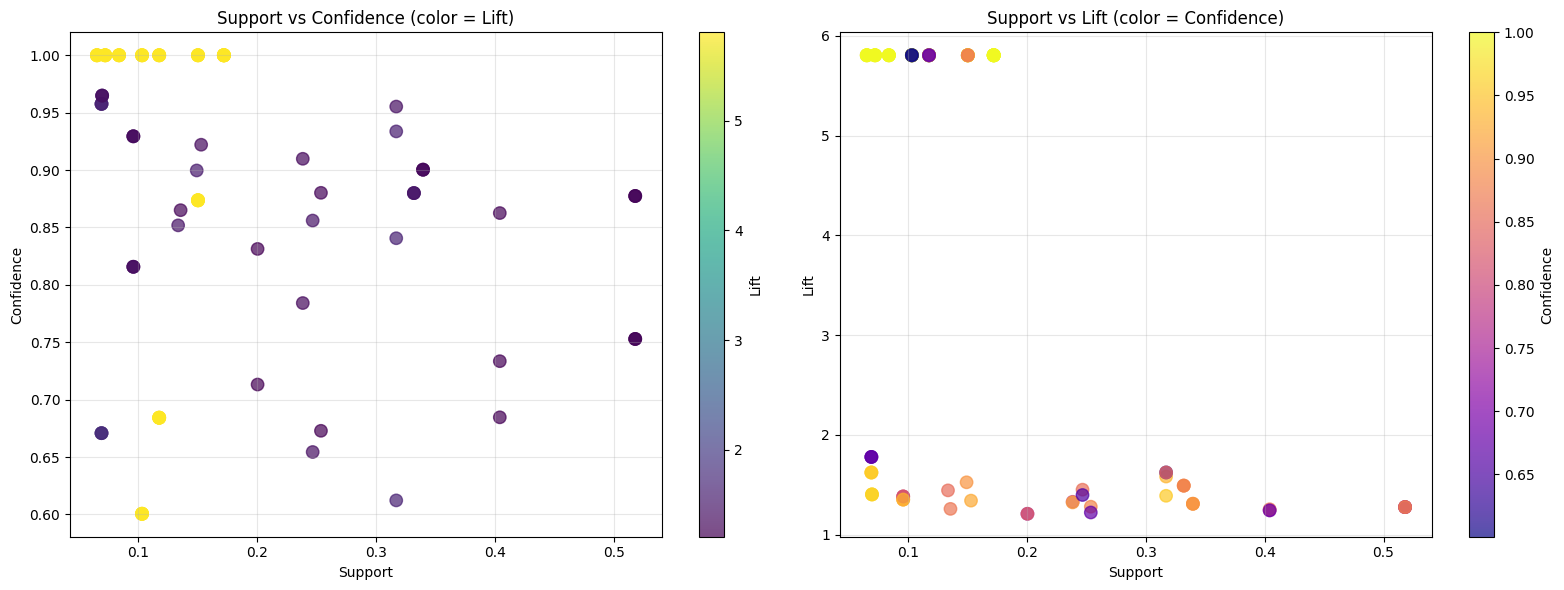

In [24]:
print("Visualizing Apriori rules (support vs confidence and lift)...")

if not rules_apriori.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sc1 = axes[0].scatter(
        rules_apriori["support"],
        rules_apriori["confidence"],
        c=rules_apriori["lift"],
        cmap="viridis",
        s=80,
        alpha=0.7,
    )
    axes[0].set_xlabel("Support")
    axes[0].set_ylabel("Confidence")
    axes[0].set_title("Support vs Confidence (color = Lift)")
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(sc1, ax=axes[0], label="Lift")

    sc2 = axes[1].scatter(
        rules_apriori["support"],
        rules_apriori["lift"],
        c=rules_apriori["confidence"],
        cmap="plasma",
        s=80,
        alpha=0.7,
    )
    axes[1].set_xlabel("Support")
    axes[1].set_ylabel("Lift")
    axes[1].set_title("Support vs Lift (color = Confidence)")
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(sc2, ax=axes[1], label="Confidence")

    plt.tight_layout()
    plt.show()
else:
    print("No Apriori rules to visualize.")

In [25]:
print("Running FP-Growth with the same parameters as Apriori...")

if not df_transactions.empty:
    frequent_itemsets_fpgrowth = fpgrowth(
        df_transactions,
        min_support=min_support,
        use_colnames=True,
        max_len=3,
    )

    print(f"Frequent itemsets found with FP-Growth: {len(frequent_itemsets_fpgrowth)}")
    if len(frequent_itemsets_fpgrowth) > 0:
        top_itemsets_fp = frequent_itemsets_fpgrowth.nlargest(10, "support")
        print("Top 10 FP-Growth itemsets by support:")
        for _, row in top_itemsets_fp.iterrows():
            items = ", ".join(sorted(list(row["itemsets"])))
            print(f"  {{{items}}}: support={row['support']:.3f} ({row['support']*100:.1f}%)")

    rules_fpgrowth = association_rules(
        frequent_itemsets_fpgrowth,
        metric="confidence",
        min_threshold=min_confidence,
    )
    rules_fpgrowth = rules_fpgrowth[rules_fpgrowth["lift"] >= min_lift]

    print(f"Total FP-Growth rules after filtering: {len(rules_fpgrowth)}")
    if len(rules_fpgrowth) > 0:
        top_rules_fp = rules_fpgrowth.nlargest(10, "lift")
        print("Top 10 FP-Growth rules by lift:")
        for _, row in top_rules_fp.iterrows():
            antecedents = ", ".join(sorted(list(row["antecedents"])))
            consequents = ", ".join(sorted(list(row["consequents"])))
            print(
                f"  IF {{{antecedents}}} THEN {{{consequents}}} | "
                f"support={row['support']:.3f}, confidence={row['confidence']:.3f}, lift={row['lift']:.3f}"
            )
else:
    frequent_itemsets_fpgrowth = pd.DataFrame()
    rules_fpgrowth = pd.DataFrame()
    print("Skipping FP-Growth: transaction matrix is empty.")

Running FP-Growth with the same parameters as Apriori...
Frequent itemsets found with FP-Growth: 132
Top 10 FP-Growth itemsets by support:
  {Reussite}: support=0.906 (90.6%)
  {Voie_professionnelle}: support=0.807 (80.7%)
  {Reussite, Voie_professionnelle}: support=0.735 (73.5%)
  {Mention_AB}: support=0.688 (68.8%)
  {Mention_AB, Reussite}: support=0.688 (68.8%)
  {Mention_B}: support=0.590 (59.0%)
  {Mention_B, Reussite}: support=0.590 (59.0%)
  {Mention_AB, Voie_professionnelle}: support=0.551 (55.1%)
  {Mention_AB, Reussite, Voie_professionnelle}: support=0.551 (55.1%)
  {Mention_AB, Mention_B}: support=0.518 (51.8%)
Total FP-Growth rules after filtering: 112
Top 10 FP-Growth rules by lift:
  IF {Serie_S} THEN {Serie_ST2S} | support=0.172, confidence=1.000, lift=5.805
  IF {Serie_ST2S} THEN {Serie_S} | support=0.172, confidence=1.000, lift=5.805
  IF {Reussite, Serie_S} THEN {Serie_ST2S} | support=0.151, confidence=1.000, lift=5.805
  IF {Reussite, Serie_ST2S} THEN {Serie_S} | sup

In [26]:
print("Comparing Apriori vs FP-Growth (itemsets and rules)...")

if not rules_apriori.empty and not rules_fpgrowth.empty:
    comparison_rules = {
        "Method": ["Apriori", "FP-Growth"],
        "Frequent itemsets": [len(frequent_itemsets_apriori), len(frequent_itemsets_fpgrowth)],
        "Rules": [len(rules_apriori), len(rules_fpgrowth)],
        "Mean support": [rules_apriori["support"].mean(), rules_fpgrowth["support"].mean()],
        "Mean confidence": [rules_apriori["confidence"].mean(), rules_fpgrowth["confidence"].mean()],
        "Mean lift": [rules_apriori["lift"].mean(), rules_fpgrowth["lift"].mean()],
    }

    comparison_rules_df = pd.DataFrame(comparison_rules)
    print("\nApriori vs FP-Growth (rules statistics):")
    print(comparison_rules_df.to_string(index=False))

    print("\nNotes:")
    if len(frequent_itemsets_apriori) == len(frequent_itemsets_fpgrowth):
        print("  Both algorithms find the same number of frequent itemsets.")
    else:
        print(
            f"  Different number of itemsets: Apriori={len(frequent_itemsets_apriori)}, "
            f"FP-Growth={len(frequent_itemsets_fpgrowth)}."
        )

    if len(rules_apriori) == len(rules_fpgrowth):
        print("  Both extract the same number of rules under these thresholds.")
    else:
        print(
            f"  Different number of rules: Apriori={len(rules_apriori)}, "
            f"FP-Growth={len(rules_fpgrowth)}."
        )

    print("  FP-Growth is generally faster than Apriori on large datasets.")
elif not rules_apriori.empty:
    print("Only Apriori produced rules; FP-Growth did not find frequent itemsets under these thresholds.")
elif not rules_fpgrowth.empty:
    print("Only FP-Growth produced rules; Apriori did not find frequent itemsets under these thresholds.")
else:
    print("No rules were produced by either algorithm with the chosen thresholds.")

Comparing Apriori vs FP-Growth (itemsets and rules)...

Apriori vs FP-Growth (rules statistics):
   Method  Frequent itemsets  Rules  Mean support  Mean confidence  Mean lift
  Apriori                132    112      0.170742         0.889825   3.997295
FP-Growth                132    112      0.170742         0.889825   3.997295

Notes:
  Both algorithms find the same number of frequent itemsets.
  Both extract the same number of rules under these thresholds.
  FP-Growth is generally faster than Apriori on large datasets.
